# Part 1: Basic Option Valuation
Carry out convergence studies by increasing the number of trials.  <br>
How do your results compare with the results obtained in assignment 1?  <br>
Perform numerical tests for varying values for the strike and the volatility parameter.  <br>
What is the standard error of your estimate and what does this tell you about the accuracy?

# TO DO 
### Romy:
- Maakt tabellen 2.1 + BS delta berekening
- Overleaf intro schrijven

### Jasper:
- [ ] 1 alle plotjes voor 1
- [ ] 2.2 pathwise controle
- [ ] 3 formules
- [ ] 3 coderen Asian option

### Steven:
- 2.2 delta uitrekeken
- 2.2 loglikelyhood


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random

from scipy.stats import norm
from numba import jit
from scipy import stats

In [2]:
# THIS IS NOW A PUT OPTION!

@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * np.random.normal())

@jit (nopython = True)
def monte_carlo_option(trials, strike_price, stock_price, interest_rate, volatility, maturity):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity)
        if current_monte - strike_price < 0:
            monte_results.append((strike_price - current_monte)/ (1 + interest_rate))
        else:
            monte_results.append(0)
        
    return monte_results 
    

In [3]:
# @jit (nopython = True)
def experiment():
    ''' The Monte Carlo method.'''
    T = 1
    K = 80
    r = 0.06
    S0 = 100
    sigma = 0.2

    trials = 10000
    time0 = time.time()

    monte_total = []
    iters = 10000
    for i in range(iters):
        monte_results = monte_carlo_option(trials, K, S0, r, sigma, T)
        # print(time.time() - time0)

        # Mean and std
        monte_mean = np.mean(monte_results)
        monte_total.append(monte_mean)
    # monte_std = np.std(monte_results)
    return monte_total

In [4]:
results = experiment()

In [5]:
np.mean(results)

0.613623056751681

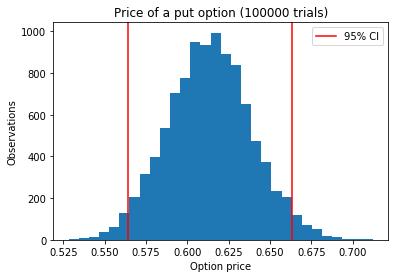

In [6]:
#Payoff kan nooit negatief zijn 
CI95 = stats.norm.interval(0.95, loc = np.mean(results), scale = np.std(results)) 
plt.axvline(CI95[0], color = 'r', label = '95% CI')
#plt.axvline(4.77, color = 'black', linestyle = ':', label = 'Black-Scholes Price')
plt.axvline(CI95[1], color = 'r')

plt.legend()
plt.hist(results, bins = 30)
plt.ylabel('Observations')
plt.xlabel('Option price')
plt.title('Price of a put option (100000 trials)')
plt.savefig("100000trialsQ21Put.png")
plt.show()

In [7]:
# '''  Varying the strike and the volatility. '''

# strike_list = [x for x in range(1,201)] #np.linspace(1,200)
# # print(strike_list)

# profit_list = []
# for K in strike_list:
#     profit = monte_carlo_option(trials, K, S0, r, sigma, T)
#     profit_list.append(profit)
     
# plt.plot(strike_list, profit)
# plt.title('Varying strike')
# plt.xlabel('Strike price')
# plt.ylabel('Profit or Loss')
# plt.legend()
# plt.show()

# Part 2: Estimation of Sensitivities in MC

## 1) Bump-and-revalue method.

In [8]:
@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity, Z):
    np.random.seed(5)
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

@jit (nopython = True)
def monte_carlo_option(trials, strike_price, stock_price, interest_rate, volatility, maturity, randomness):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        if current_monte - strike_price < 0:
            monte_results.append((strike_price - current_monte)/ (1 + interest_rate))
        else:
            monte_results.append(0)
        
    return monte_results 
    

In [9]:
def experiment(epsilon, randommess, trials = 1000):
    ''' The Monte Carlo method.'''
    T = 1
    K = 99
    r = 0.06
    S0 = 100 + epsilon
    sigma = 0.2

#     time0 = time.time()

    monte_total = []
    iters = 1
    for i in range(iters):
        monte_results = monte_carlo_option(trials, K, S0, r, sigma, T, randommess)
        # print(time.time() - time0)

        # Mean 
        monte_mean = np.mean(monte_results)
        monte_total.append(monte_mean)

    return monte_total

In [10]:
def euler(epsilon, trials, randommess = np.random.normal(size=1000), sameseed = True):    
    bumped = np.mean(experiment(epsilon, randommess, trials))
    if not sameseed:
        randommess = np.random.normal(size=number_of_trials)
    unbumped = np.mean(experiment(0, randommess, trials))
    
    delta = (bumped - unbumped) / epsilon
    return delta

In [11]:
""" Compute deltas for different seeds
    with epsilon 0.01, 0.02, 0.5. """

# Size 10^4
number_of_trials = int(1e4)
randommess = np.random.normal(size= number_of_trials)
dif_delta4_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
dif_delta4_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta4_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

# # Size 10^5
# number_of_trials = int(1e5)
# randommess = np.random.normal(size=number_of_trials)
# dif_delta5_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta5_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta5_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

# # Size 10^6
# number_of_trials = int(1e6)
# randommess = np.random.normal(size=number_of_trials)
# dif_delta6_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta6_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta6_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

# # Size 10^7
# number_of_trials = int(1e7)
# randommess = np.random.normal(size=number_of_trials)
# dif_delta7_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta7_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta7_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

In [12]:
# """ Compute deltas for same seed 
#     with epsilon 0.01, 0.02, 0.5. """

# Size 10^4
number_of_trials = int(1e4)
randommess = np.random.normal(size=number_of_trials)
same_delta4_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

# # Size 10^5
# number_of_trials = int(1e5)
# randommess = np.random.normal(size=number_of_trials)
# same_delta5_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta5_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta5_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

# # Size 10^6
# number_of_trials = int(1e6)
# randommess = np.random.normal(size=number_of_trials)
# same_delta6_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta6_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta6_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

# # Size 10^7
# number_of_trials = int(1e7)
# randommess = np.random.normal(size=number_of_trials)
# same_delta7_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta7_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta7_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

In [18]:
""" Relative error in percentage. """
def relative_error(true_value, approx_value):
    return ((true_value - approx_value) / true_value) * 100

In [21]:
'''Analytical value'''
def black_scholes(stock_price = 100, strike_price = 80, interest_rate = 0.06, volatility = 0.2, T = 1):
    d1 = (math.log(stock_price / strike_price) + (interest_rate + (volatility ** 2) / 2) * T) / (volatility * math.sqrt(T))
    #d2 = d1 - volatility* math.sqrt(T)
    d2 = (math.log(stock_price / strike_price) + (interest_rate - (volatility ** 2) / 2) * T) / (volatility * math.sqrt(T))
   
    call = stock_price * norm.cdf(d1) - strike_price * math.exp(- interest_rate * T) * norm.cdf(d2)
    put = strike_price * math.exp(-interest_rate * T ) * norm.cdf(-d2) - stock_price * norm.cdf(-d1)

    return call, put


""" Relative error is shown with analytical value as reference. """

#The analytical value
analytical_call, analytical_put = black_scholes()
# print('The analytical price of the option:', analytical_put)

#######
# print(dif_delta4_1)
# print(dif_delta4_2)

number_of_trials = 100000
randommess = np.random.normal(size=number_of_trials)
# print(len(randommess))
check = euler(1e-8, trials = number_of_trials, randommess = randommess, sameseed=True)
print('Check', check)
#####

# Size 10^4
number_of_trials = int(1e4)
randommess = np.random.normal(size=number_of_trials)
same_delta4_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

####
analytical_value = -0.326265
print('analytical value:', analytical_value)
print('calculated value', same_delta4_1)
error = relative_error(analytical_value, same_delta4_1)
print('Error', error)

Check -0.3244055690743153
analytical value: -0.326265
calculated value -0.3302506584851095
Error -1.221601607622471


In [22]:
""" Relative error is shown with analytical value as reference. """

#The analytical value
analytical_call, analytical_put = black_scholes()
print('The analytical price of the option:', analytical_put)

#######
# print(dif_delta4_1)
# print(dif_delta4_2)

number_of_trials = 100000
randommess = np.random.normal(size=number_of_trials)
# print(len(randommess))
check = euler(1e-8, trials = number_of_trials, randommess = randommess, sameseed=True)
print(check)

####
error = relative_error(analytical_put, check)
print(error)

The analytical price of the option: 0.6126580614975463
-0.32640699032526754
153.27718850665525


## 2)  Digital option

In [23]:
import scipy

In [54]:
def experiment2(epsilon, trials = 1000):
    ''' The Monte Carlo method.'''
    T = 1
    K = 100
    r = 0
    S0 = 100 + epsilon
    sigma = 0.2

#     time0 = time.time()

    monte_total = []
    newglobel = []
    iters = 10000
    for i in range(iters):
        randommess = np.random.normal(size = trials)
        monte_results = digital_option(trials, K, S0, r, sigma, T, randommess)
        newglobel.append(monte_results[1])
        # print(time.time() - time0)

        monte_mean = np.mean(monte_results[0])
        monte_total.append(monte_mean)

    return monte_total

#@jit (nopython = True)
def digital_option(trials, strike_price, stock_price, interest_rate, volatility, maturity, randomness):
    # trials are #iterations of monte carlo
    globallist = []
    monte_results = []
    
    acounter = 0
    bcounter = 0
    
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        globallist.append(current_monte)
        if current_monte - strike_price > 0:
            monte_results.append(math.exp(-interest_rate * T))
            acounter = acounter + 1
        else:
            monte_results.append(0)
            bcounter = bcounter + 1
    #print(acounter)
    #print(bcounter)
    #print()
    #plt.hist(globallist)
    #plt.show()
    return monte_results, np.mean(globallist)

#@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

(array([   4.,   78.,  424., 1388., 2936., 3141., 1556.,  388.,   80.,
           5.]),
 array([0.395, 0.408, 0.421, 0.434, 0.447, 0.46 , 0.473, 0.486, 0.499,
        0.512, 0.525]),
 <a list of 10 Patch objects>)

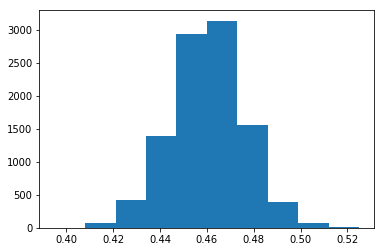

In [55]:
plt.hist(experiment2(0.0))

In [49]:
def digital_optionJ(trials=100000, strike_price=99, stock_price=100, interest_rate=0.06, volatility=0.2, maturity=1):
    randomness = np.random.normal(size = trials)
    # trials are #iterations of monte carlo
    globallist = []
    monte_results = []
    
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        globallist.append(current_monte)
        if current_monte - strike_price > 0:
            monte_results.append(math.exp(-r * T) * current_monte / stock_price)
        else:
            monte_results.append(0)
    return monte_results, np.mean(globallist)

#@jit (nopython = True)
def one_step_stockJ(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

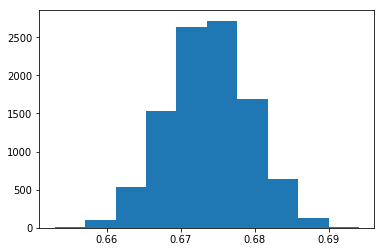

In [51]:
delta_list = []
for i in range(10000):
    delta_list.append(np.mean(digital_optionJ()[0]))
    
plt.hist(delta_list)
plt.show()


# Part 3: Variance Reduction

In [125]:
def asian_option_pathJ(N=100, strike_price=99, stock_price=100, interest_rate=0.06, volatility=0.2, maturity=1):
    randomness = np.random.normal(size = N)
    # trials are #iterations of monte carlo
    Si = np.zeros(N + 1)
    Si[0] = stock_price
    
    for i in range(N):
    
        Si[i+1] = one_step_stock(Si[i], interest_rate, volatility, 1/N, randomness[i])
      
    return np.max(np.prod(Si[1:])**(1/(N)))
  

def asian_option(t, stock_price, strike_price=99, interest_rate=0.06, volatility=0.2, maturity=1):
    if t == maturity:
        return np.max(stock_price - strike_price , 0)
    
    return 
    
    
#@jit (nopython = True)
def one_step_stockJ(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

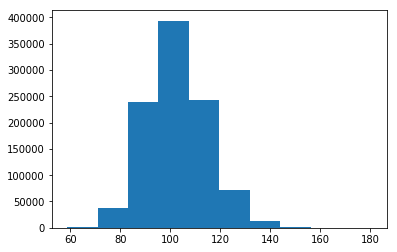

102.73385146265711


In [129]:
asian_call = []
for _ in range(1000000):
    asian_call.append(asian_option_pathJ())
plt.hist(asian_call)
plt.show()
print(np.mean(asian_call))

In [127]:
def analytic_solution(start_price = 100, T = 1, N = 100, r = 0.06, sigma = 0.2):
    mu = (r - 0.5 * sigma**2) * (N + 1) / (2 * N) * T
    sig = sigma**2 * ((N + 1) * (2 * N + 1) / (6 * N**2) * T)
    return  start_price * math.exp(mu + sig**2/2)
    

In [111]:
analytic_solution()

102.04988583777359